## Interchange Intervention


In [1]:
__author__ = "Aryaman Arora and Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce some of the results in this [notebook](https://github.com/aryamanarora/nano-causal-interventions/blob/main/The%20capital%20of%20France%20is.ipynb) for path patching or causal scrubbing. This library could potentially support other kinds of interventions that were not originally supported by previous works.


### Set-up


In [2]:
import pyvene

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
import pandas as pd
import pyvene
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual recall


In [13]:
config, tokenizer, gpt = pyvene.create_gpt2()

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"), tokenizer(source, return_tensors="pt")]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Poland is the city named
_after               0.8297877907752991
_for                 0.05746651068329811
_in                  0.014184350147843361
_by                  0.009943760000169277
_"                   0.007809711620211601
_as                  0.0037258455995470285
_the                 0.003700744826346636
_'                   0.003235934767872095
_with                0.0026704727206379175
_Warsaw              0.002544724615290761

The capital of France is the city named
_after               0.7571142911911011
_for                 0.103834368288517
_in                  0.01621975004673004
_by                  0.01177014410495758
_"                   0.00935616809874773
_the                 0.005509068723767996
_'                   0.004434842150658369
_with                0.0037160939536988735
_as                  0.002572472905740142
_on                  0.002448666375130415


### Patch Patching on Position-aligned Tokens

We path patch on two modules on each layer:

- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)


In [7]:
def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

In [8]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt.config.n_layer):
    config = simple_position_config(type(gpt), "mlp_output", layer_i)
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    config = simple_position_config(type(gpt), "attention_input", layer_i)
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"a{layer_i}",
                    "pos": pos_i,
                    "type": "attention_input",
                }
            )
df = pd.DataFrame(data)
df.head()

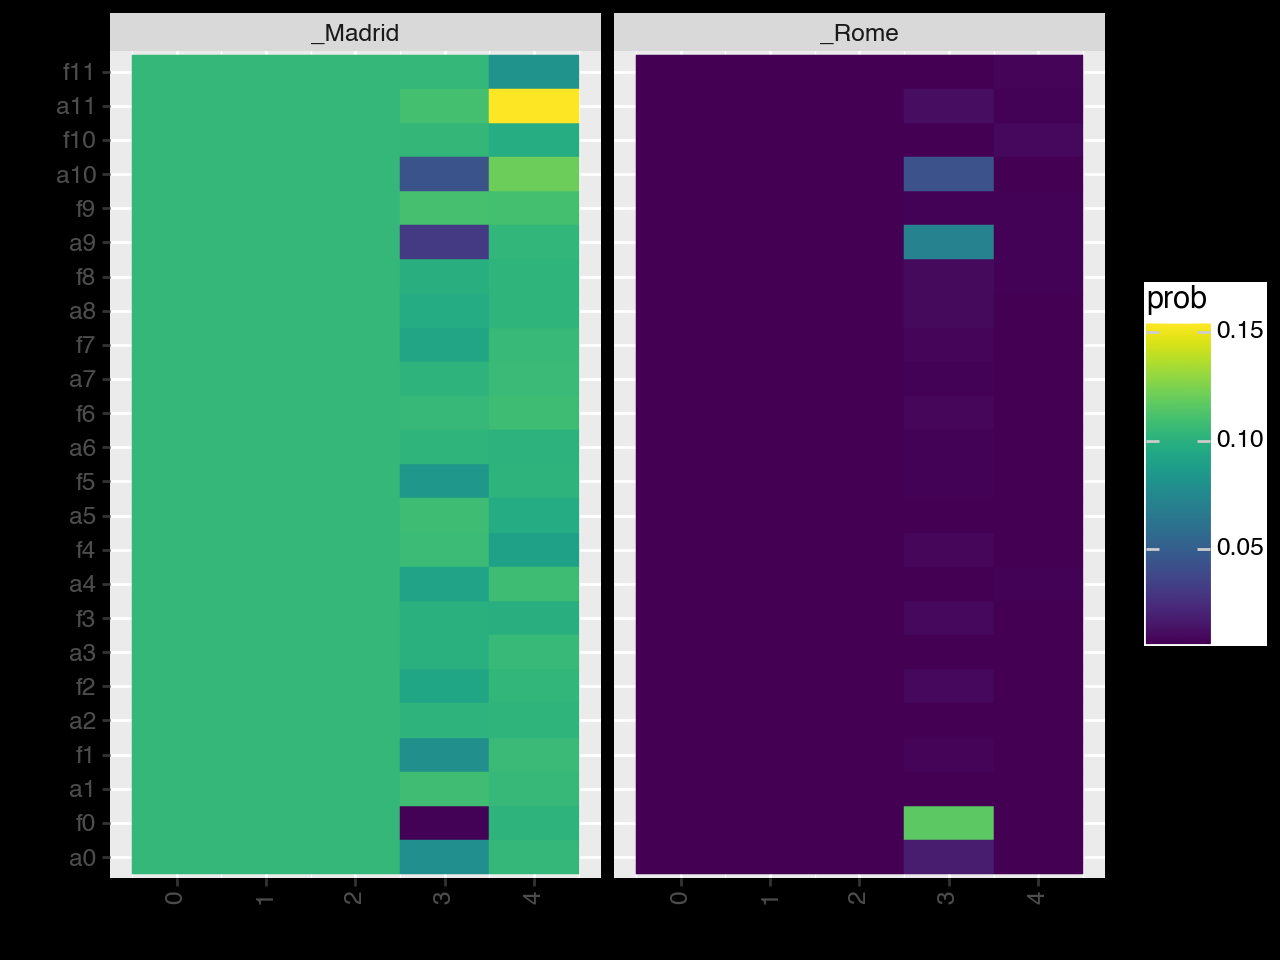

In [11]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"f{l}")
    nodes.append(f"a{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
g

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


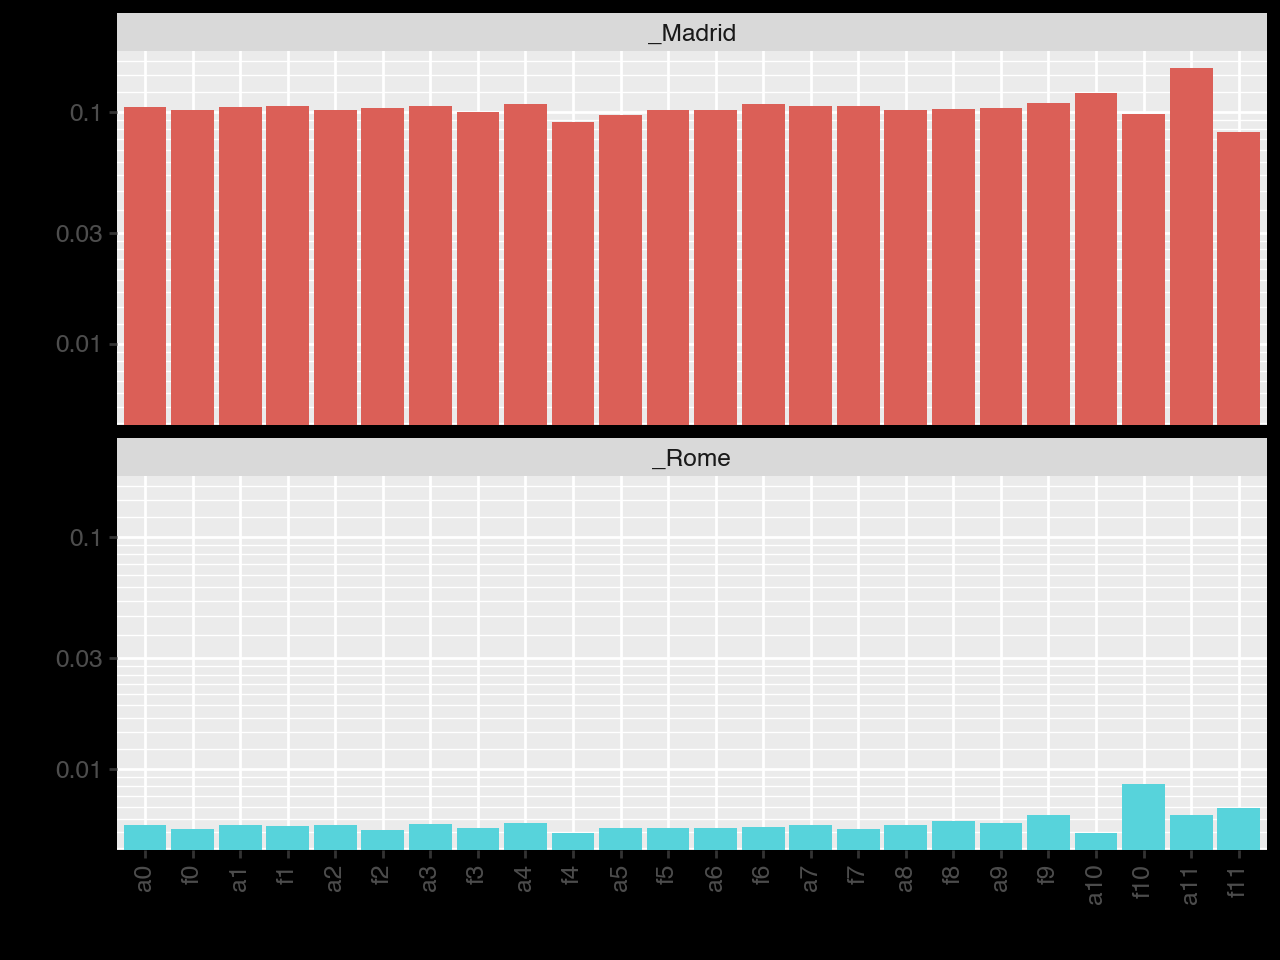

In [12]:
filtered = df
filtered = filtered[filtered["pos"] == 4]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
g